In [1]:
import torch
import geospaNN
import numpy as np
import time
import pandas as pd
import seaborn as sns
import random

import matplotlib
import matplotlib.pyplot as plt

path = '../data/Output/'

R[write to console]: Loading required package: BRISC

R[write to console]: Loading required package: RANN

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: rdist

R[write to console]: Loading required package: matrixStats

R[write to console]: Loading required package: pbapply

R[write to console]: The ordering of inputs x (covariates) and y (response) in BRISC_estimation has been changed BRISC 1.0.0 onwards.
  Please check the new documentation with ?BRISC_estimation.



R package: BRISC installed


/Users/zhanwentao/opt/anaconda3/envs/NN/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def RMSE(x,y):
    x = x.reshape(-1)
    y = y.reshape(-1)
    n = x.shape[0]
    return(np.sqrt(np.sum(np.square(x-y))/n))

In [3]:
def f5(X): return (10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4]) / 6


def f1(X): return 10 * np.sin(2*np.pi * X)

p = 1;
funXY = f1

n = 1000
nn = 20
batch_size = 50

sigma = 1
phi = 0.3
tau = 0.01
theta = torch.tensor([sigma, phi / np.sqrt(2), tau])

X, Y, coord, cov, corerr = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, 1])

In [4]:
torch.manual_seed(2025)
_, _, _, _, X = geospaNN.Simulation(n, p, nn, funXY, torch.tensor([1, 5, 0.01]), range=[0, 1])
X = X.reshape(-1,p)
X = (X - X.min())/(X.max() - X.min())
torch.manual_seed(2025)
_, _, coord, cov, corerr = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, 1])
Y = funXY(X).reshape(-1) + corerr

In [5]:
data = geospaNN.make_graph(X, Y, coord, nn, Ind_list = None)

torch.manual_seed(2024)
np.random.seed(0)
data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size=nn, 
                                                      test_proportion=0.2, val_proportion=0.2)

In [6]:
def linear_gls(data_train):
    beta, theta_hat_BRISC = geospaNN.BRISC_estimation(data_train.y.detach().numpy(),
                                                      torch.concat([torch.ones(data_train.x.shape[0], 1), data_train.x],
                                                                   axis=1).detach().numpy(),
                                                      data_train.pos.detach().numpy())
    def mlp_BRISC(X):
        return beta[0] + torch.Tensor(beta[1:]) * X

    model = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_BRISC, theta=torch.tensor(theta_hat_BRISC))
    return model

In [7]:
model_linear = linear_gls(data_train)

---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 2 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------


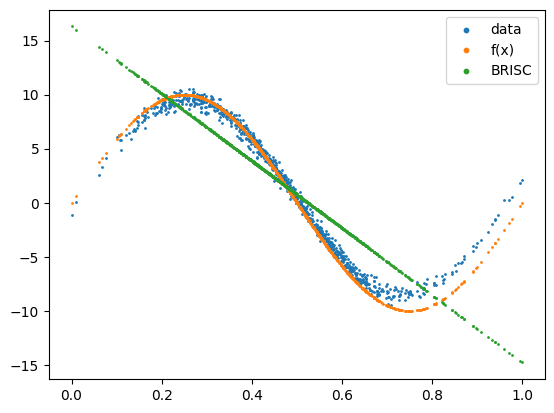

In [8]:
estimate = model_linear.estimate(X)
plt.clf()
plt.scatter(X.detach().numpy(), Y.detach().numpy(), s=1, label='data')
plt.scatter(X.detach().numpy(), funXY(X.detach().numpy()), s=1, label='f(x)')
plt.scatter(X.detach().numpy(), estimate, s=1, label='BRISC')
lgnd = plt.legend()
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])
plt.savefig(path + 'Estimation_linear.png')

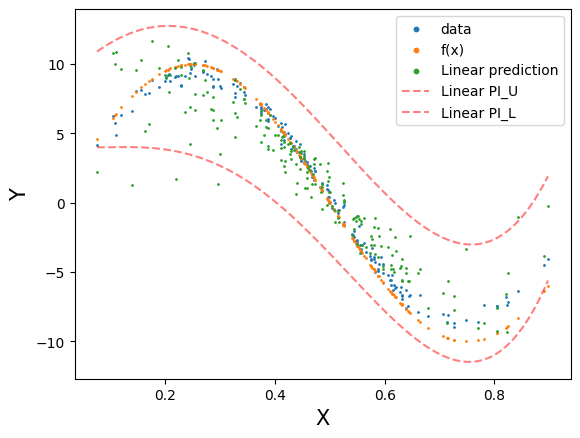

In [11]:
[test_predict, test_PI_U, test_PI_L] = model_linear.predict(data_train, data_test, CI = True)
x_np = data_test.x.detach().numpy().reshape(-1)
x_smooth = np.linspace(x_np.min(), x_np.max(), 200)  # Create finer x-points
degree = 4
U_fit = np.polyfit(x_np, test_PI_U, degree)
L_fit = np.polyfit(x_np, test_PI_L, degree)
Pred_fit = np.polyfit(x_np, test_predict, degree)

# Evaluate the polynomial on a smooth grid
y_smooth_U = np.polyval(U_fit, x_smooth)
y_smooth_L = np.polyval(L_fit, x_smooth)
y_smooth = np.polyval(Pred_fit, x_smooth)

plt.clf()
plt.scatter(data_test.x.detach().numpy(), data_test.y.detach().numpy(), s=1, label='data')
plt.scatter(data_test.x.detach().numpy(), funXY(data_test.x.detach().numpy()), s=1, label='f(x)')
plt.scatter(data_test.x.detach().numpy(), test_predict.detach().numpy(), s=1, label='Linear prediction')
plt.plot(x_smooth, y_smooth_U, linestyle='--', label='Linear PI_U', color = 'red', alpha = 0.5)
plt.plot(x_smooth, y_smooth_L, linestyle='--', label='Linear PI_L', color = 'red', alpha = 0.5)
plt.xlabel("X", fontsize=15)
plt.ylabel("Y", fontsize=15)
lgnd = plt.legend()
for handle in lgnd.legend_handles[:3]:
    handle.set_sizes([10.0])
plt.savefig(path + "Prediction_linear.png")